# Cluster Analysis (Hierarchical & K-Means)

## Introduction and Business Problem
Compnay XYZ, a wholesales distributor operating in Portugal serves a diverse range of business clients, including retailer, restaurants, hotels and cafes. The marketing manager of XYZ want to understand more about their clients' spending patterns. By gaining insights, the goal of this anlaysis is to help XYZ company to tailor their strategies to satisfy clients' demand and manage inventory well. 

## Procedure of Analsis
To find out clients' spending patterns, I implemented clustering analysis using python. I implemented hierarchical and k-means clustering in this dataset. This algorithm helps group similar data together into a specific number of clusters. After finding out specific clusters, I tried to understand differenct clusters of clents by exploring data anlaysis. Based on insights I gain, I provied suggested recommendations for XYZ company.

### Variable Name Description
- Channel: Client channel (“1” means Horeca (Hotel/Restaurant/Cafe) and
“2” means Retail)
- Region: Client region (“1” means Lisbon, “2” means Oporto, and “3” means
other regions)
- Fresh: Annual spending on fresh products.
- Milk: Annual spending on milk products.
- Grocery: Annual spending on grocery products.
- Frozen: Annual spending on frozen products.
- Detergents Paper: Annual spending on detergents and paper products.
- Delicatessen: Annual spending on deli products.

### Table of contents:
1. Problem defining and our overall rationale to solve it
2. EDA before Clustering
3. Hierarchical Clustering:
to derive an initial idea of clustering number then conduct k-means clustering to check based on
the evaluation of SSE curve, cluster plot, and Silhouette coefficient.
4. K-Means Clustering:
to see if our cluster number is appropriate and reasonable to do further interpretation. If yes, the
data with cluster label we use in the managerial document is from hierarchical clustering, since the
cluster labels of k-means clustering are different each time (same pattern, different labels assigned)
5. Evaluate Clustering Solutions: SSE, cluster plot, and Slihouette Coefficient.
6. Analysis after clustering
7. Summary for clustering and other analysis results
8. Translate analyzing results into business solutions outline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler

### Problem Define and Rationale to Solve the problem

#### General goal for analysis
To get a deeper understanding of the spending patterns of the clients.
Specific goal for analysis:
1. conduct clustering analysis and discover different patterns of spending for each cluster.
2. we need to do EDA before moving on to further analysis, and we are going to combine
analysis from that as well as clustering to provide data support for business solutions.
3. we will translate analyzing results into business solutions outline, and more detailed
business strategies will be presented in our managerial document.

In [2]:
wholesales = pd.read_csv("Wholesale customers data.csv")
wholesales.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
wholesales.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
### There are 440 data points. XYZ company's clients average spent the most on Fresh Food

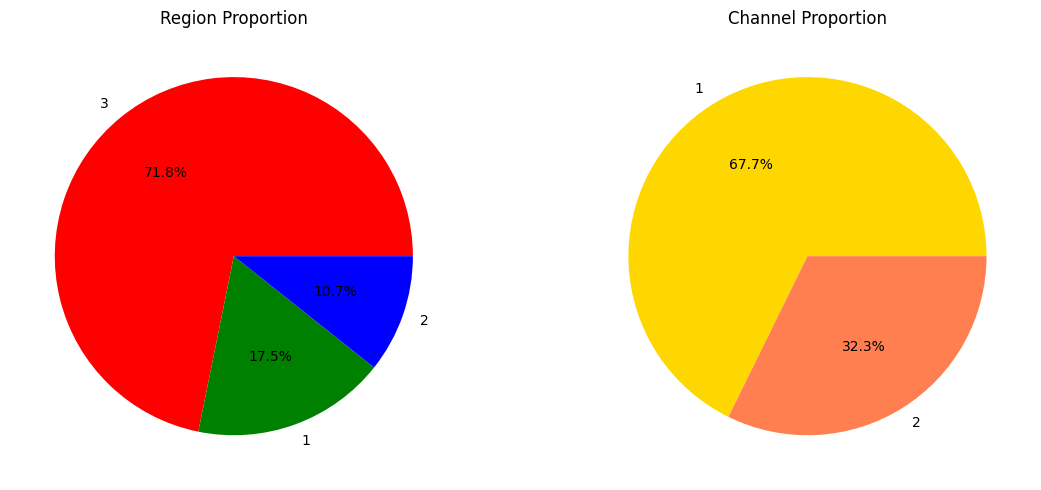

In [5]:
# calculate the proportions for Region and Channel
region_count = wholesales["Region"].value_counts()
channel_count = wholesales["Channel"].value_counts()

# create a 1X2 grid for the pie charts with equal aspect ratio
plt.figure(figsize=(12,5))

# create a pie chart for Region
plt.subplot(1, 2, 1, aspect='equal')
plt.pie(region_count, labels = region_count.index, autopct= "%1.1f%%", colors= ["r","g","b"])
plt.title("Region Proportion")

# create a pie chart for Channel
plt.subplot(1,2,2, aspect = "equal")
plt.pie(channel_count, labels = channel_count.index, autopct= "%1.1f%%", colors= ["gold", "coral"])
plt.title("Channel Proportion")
plt.tight_layout()
plt.show()

- Based on the pie chart, other regions contributed the most. However, if only take region 1 and 2 into consideration, XYZ company focus more on Lisbon region (region 1). Also, channel 1 (Horeca) is twice than channel 2 (Retail).

In [6]:
## Check the correlation among variables to get a conceptual and general understanding of the dataset
corr_matrix = wholesales.iloc[:, 3:9].corr()
corr_matrix

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Milk,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.406368,0.205497,0.390947,0.069291,1.000000


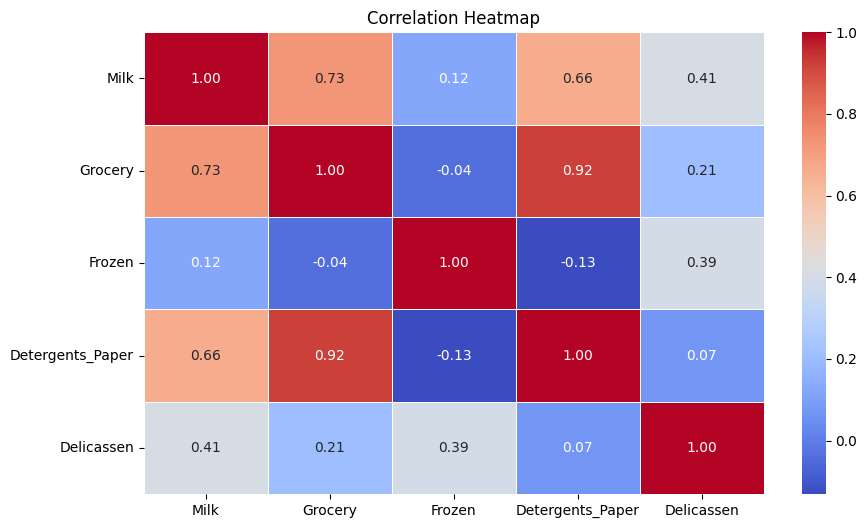

In [7]:
# create a correlation heatmap
plt.figure(figsize =(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

- From the plot above, we found no obvious negative correlation between variables. What we believe more worth highlighting is the relatively strong positive correlation between Grocery and Detergents_Paper, and then are Milk and Grocery, Milk and Detergent_Paper.

In [8]:
# Group the data by Region and Channel
channel_grouped = wholesales[["Channel", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("Channel").sum()
channel_grouped.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,
1,1028614,1180717,1116979,235587,421955
2,1521743,2317845,234671,1032270,248988


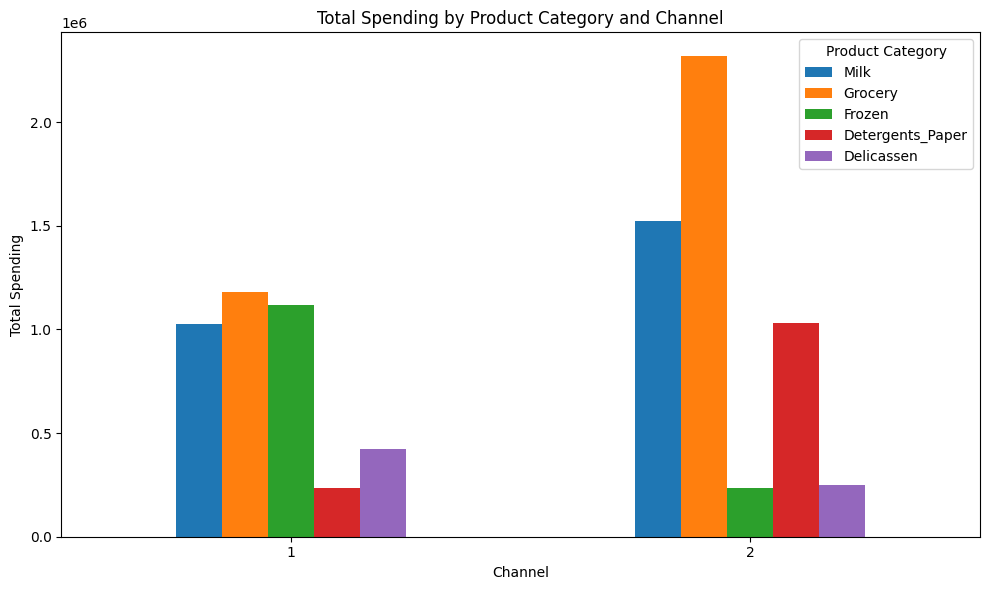

In [9]:
# Create a bar chart
channel_grouped.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Channel')
plt.ylabel('Total Spending')
plt.title('Total Spending by Product Category and Channel')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# Group the data by Region and Channel
channel_grouped = wholesales[["Region", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("Region").sum()
channel_grouped.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,
1,422454,570037,231026,204136,104327
2,239144,433274,190132,173311,54506
3,1888759,2495251,930492,890410,512110


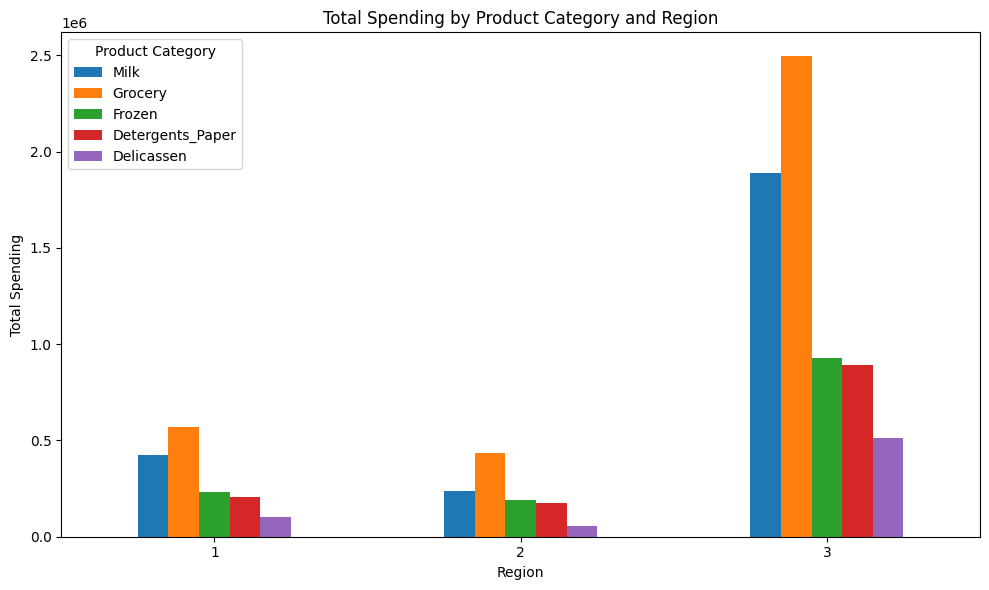

In [11]:
# Create a bar chart
channel_grouped.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Region')
plt.ylabel('Total Spending')
plt.title('Total Spending by Product Category and Region')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Group the data by Region and Channel
channel_mean = wholesales[["Channel", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("Channel").mean()
channel_mean.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,
1,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


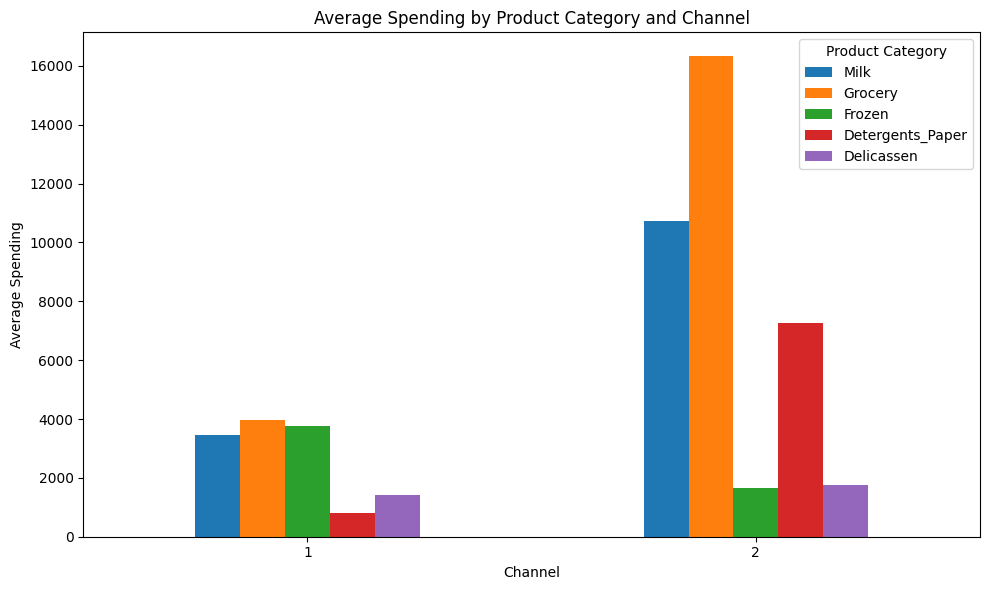

In [13]:
# Create a bar chart
channel_mean.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Channel')
plt.ylabel('Average Spending')
plt.title('Average Spending by Product Category and Channel')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Group the data by Region and Channel
region_mean = wholesales[["Region", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("Region").mean()
region_mean.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,
1,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
2,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
3,5977.085443,7896.363924,2944.594937,2817.753165,1620.601266


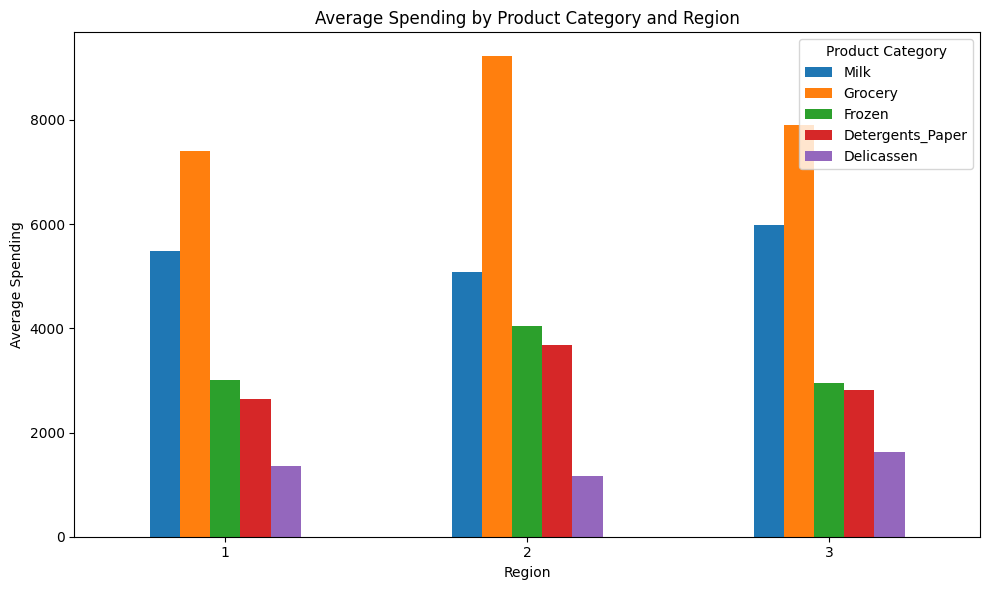

In [15]:
# Create a bar chart
region_mean.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Region')
plt.ylabel('Average Spending')
plt.title('Average Spending by Product Category and Region')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Hierarchical Clustering
### Calculate Distances

In [16]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler

In [17]:
## Normalize the data using Min-Max normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(wholesales.iloc[:, 3:9])
normalized_df = pd.DataFrame(normalized_data, columns= wholesales.columns[3:9])
normalized_df.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.130727,0.081464,0.003106,0.065427,0.027847
1,0.132824,0.103097,0.028548,0.080590,0.036984
2,0.119181,0.082790,0.039116,0.086052,0.163559
3,0.015536,0.045464,0.104842,0.012346,0.037234
4,0.072914,0.077552,0.063934,0.043455,0.108093


In [18]:
## calculate the distance matrix using Euclian distance
from scipy.spatial.distance import pdist
distance_matrix = pdist(normalized_df, metric='euclidean')

## Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method="ward")

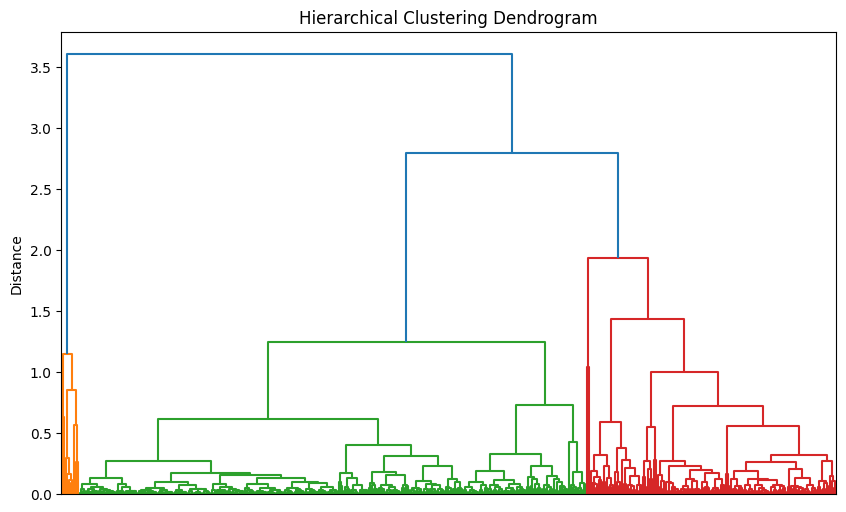

In [19]:
# Calculate the condensed distance matrix using Euclidean distance
from scipy.spatial.distance import pdist
distance_matrix = pdist(normalized_df, metric='euclidean')

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot the dendrogram without x-axis labels
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, no_labels=True)  # Set no_labels=True to hide x-axis labels
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.show()

## K-means

### Use the k-means method to do the clustering analysis. I plotted a SSE curve to look into the proper number of clusters.

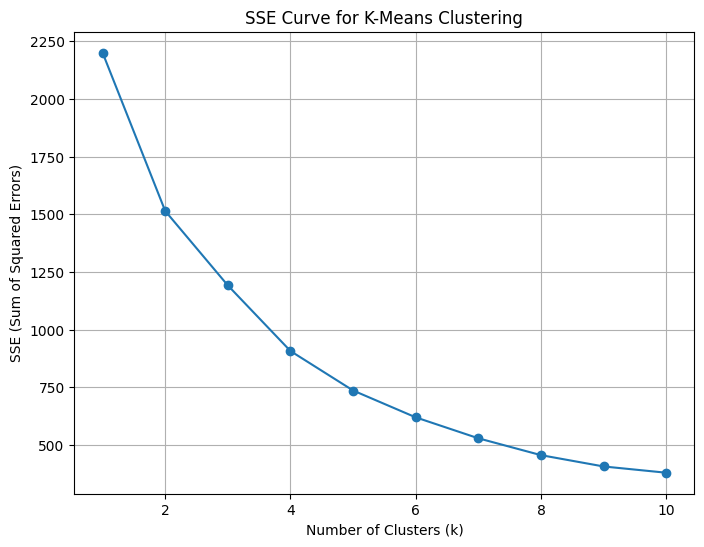

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Select the features you want to use for clustering
features = wholesales[["Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]

# Standardize the data (important for k-means)
scaler = StandardScaler()
kmeans = KMeans(n_init=10)

# Create a pipeline for standardization and k-means clustering
pipeline = make_pipeline(scaler, kmeans)

# Calculate SSE (Sum of Squared Errors) for different values of k
sse = []
for k in range(1, 11):
    pipeline.named_steps['kmeans'].n_clusters = k
    pipeline.fit(features)
    sse.append(pipeline.named_steps['kmeans'].inertia_)

# Plot the SSE curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('SSE Curve for K-Means Clustering')
plt.grid(True)
plt.show()

### From the SSE curve above, we could tell the elbow point is 4 or 5 clusters. Hence we need to further see how these two clusters work to cluster the dataset. First, we try 5 cluster because the slop of k=5 is less steep.

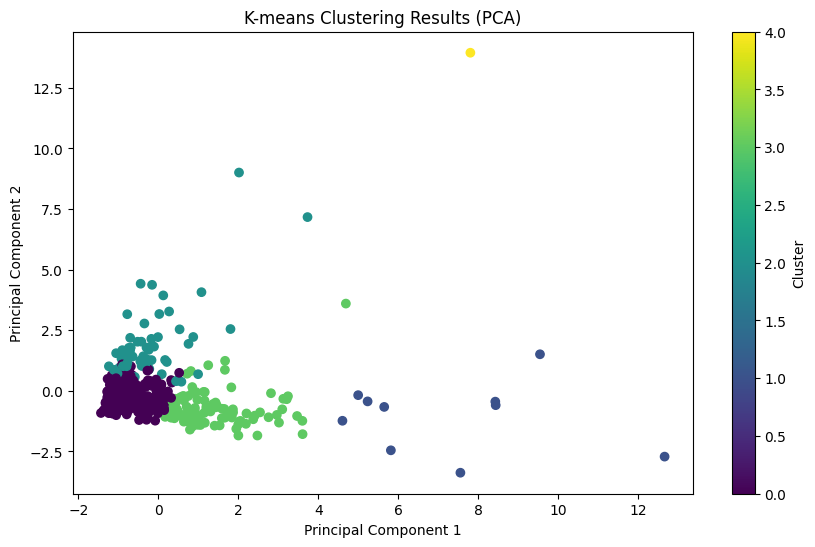

In [21]:
from sklearn.decomposition import PCA

# Select the columns you want to use for clustering
selected_columns = wholesales[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]

# Create a StandardScaler instance
scaler = StandardScaler()

# Normalize the selected columns
normalized_data = scaler.fit_transform(selected_columns)

# Set the number of clusters to 5
k = 5

# Create and fit the K-means model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
wholesales['cluster'] = kmeans.fit_predict(normalized_data)

# Apply PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)

# Visualize the clusters in 2D using PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=wholesales['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results (PCA)')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
# Set the number of clusters to 5
# Group the data by the 'cluster' column
cluster_grouped = wholesales.groupby('cluster')

# Iterate through each cluster and print the information
for cluster, group_data in cluster_grouped:
    num_data_points = len(group_data)
    avg_spending = group_data[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].mean()
    
    print(f"Cluster {cluster}:")
    print(f"Number of Data Points: {num_data_points}")
    print("Average Spending Across Categories:")
    print(avg_spending)
    print("\n")

Cluster 0:
Number of Data Points: 270
Average Spending Across Categories:
Fresh               9092.155556
Milk                2967.759259
Grocery             3807.411111
Frozen              2271.759259
Detergents_Paper     989.814815
Delicassen           978.962963
dtype: float64


Cluster 1:
Number of Data Points: 10
Average Spending Across Categories:
Fresh               15964.9
Milk                34708.5
Grocery             48536.9
Frozen               3054.6
Detergents_Paper    24875.2
Delicassen           2942.8
dtype: float64


Cluster 2:
Number of Data Points: 63
Average Spending Across Categories:
Fresh               32957.984127
Milk                 4997.349206
Grocery              5884.761905
Frozen               8422.841270
Detergents_Paper      954.603175
Delicassen           2462.968254
dtype: float64


Cluster 3:
Number of Data Points: 96
Average Spending Across Categories:
Fresh                5754.166667
Milk                10866.604167
Grocery             16607.104167

### When clusters = 5, the cluster 4 would contain only 1 data point. This would not make any sense in real world explanation. Hence, I further try out 4 clusters to see if the clusters make more sense.

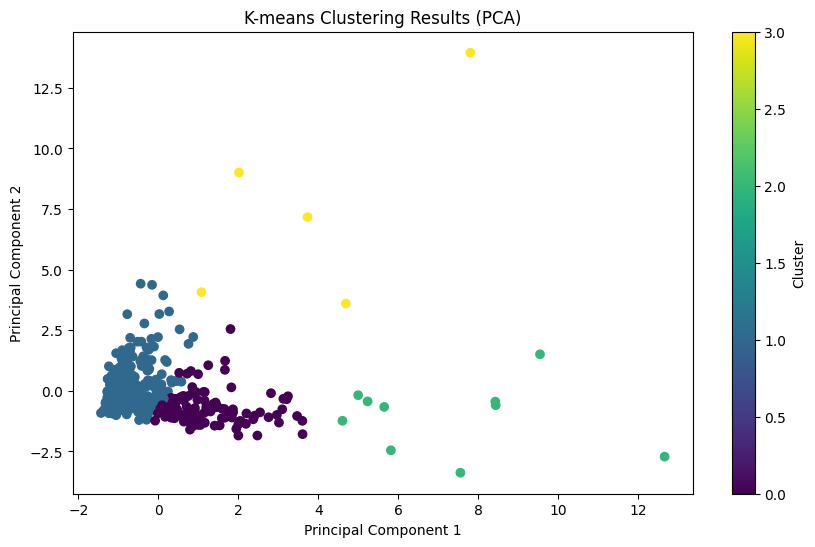

In [23]:
# Set the number of clusters to 4
k = 4

# Create and fit the K-means model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
wholesales['cluster'] = kmeans.fit_predict(normalized_data)

# Apply PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)

# Visualize the clusters in 2D using PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=wholesales['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results (PCA)')
plt.colorbar(label='Cluster')
plt.show()

In [24]:
# Set the number of clusters to 4
# Group the data by the 'cluster' column
cluster_grouped = wholesales.groupby('cluster')

# Iterate through each cluster and print the information
for cluster, group_data in cluster_grouped:
    num_data_points = len(group_data)
    avg_spending = group_data[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].mean()
    
    print(f"Cluster {cluster}:")
    print(f"Number of Data Points: {num_data_points}")
    print("Average Spending Across Categories:")
    print(avg_spending)
    print("\n")

Cluster 0:
Number of Data Points: 110
Average Spending Across Categories:
Fresh                5591.436364
Milk                10113.027273
Grocery             15637.390909
Frozen               1499.918182
Detergents_Paper     6711.354545
Delicassen           1759.090909
dtype: float64


Cluster 1:
Number of Data Points: 315
Average Spending Across Categories:
Fresh               13504.987302
Milk                 3044.539683
Grocery              3844.444444
Frozen               3271.425397
Detergents_Paper      852.320635
Delicassen           1127.107937
dtype: float64


Cluster 2:
Number of Data Points: 10
Average Spending Across Categories:
Fresh               15964.9
Milk                34708.5
Grocery             48536.9
Frozen               3054.6
Detergents_Paper    24875.2
Delicassen           2942.8
dtype: float64


Cluster 3:
Number of Data Points: 5
Average Spending Across Categories:
Fresh               50270.6
Milk                26361.8
Grocery             16416.0
Frozen  

In [25]:
wholesales.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1


### After combined the insights from Hierarchical Clustering and K-means Clustering, I would pick 4 clusters and do further analysis based on these clusters.

In [26]:
# Group the data by Region and Channel
cluster_total = wholesales[["cluster", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("cluster").sum()
cluster_total.head()

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,
0,1112433,1720113,164991,738249,193500
1,959030,1211000,1030499,268481,355039
2,347085,485369,30546,248752,29428
3,131809,82080,125614,12375,92976


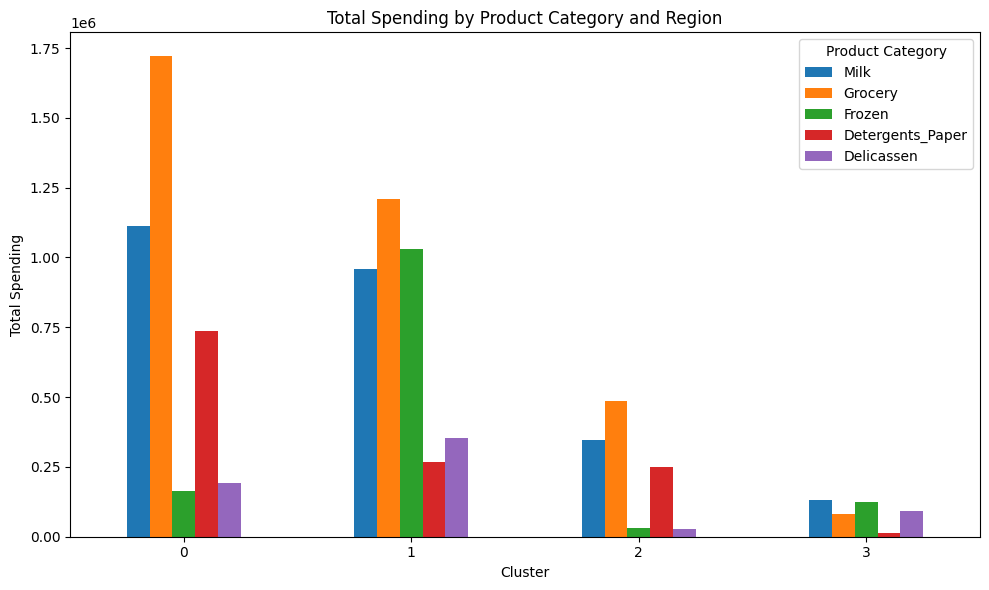

In [27]:
# Group the data by Cluster and calculate the total spending
cluster_total.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Total Spending')
plt.title('Total Spending by Product Category and Region')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

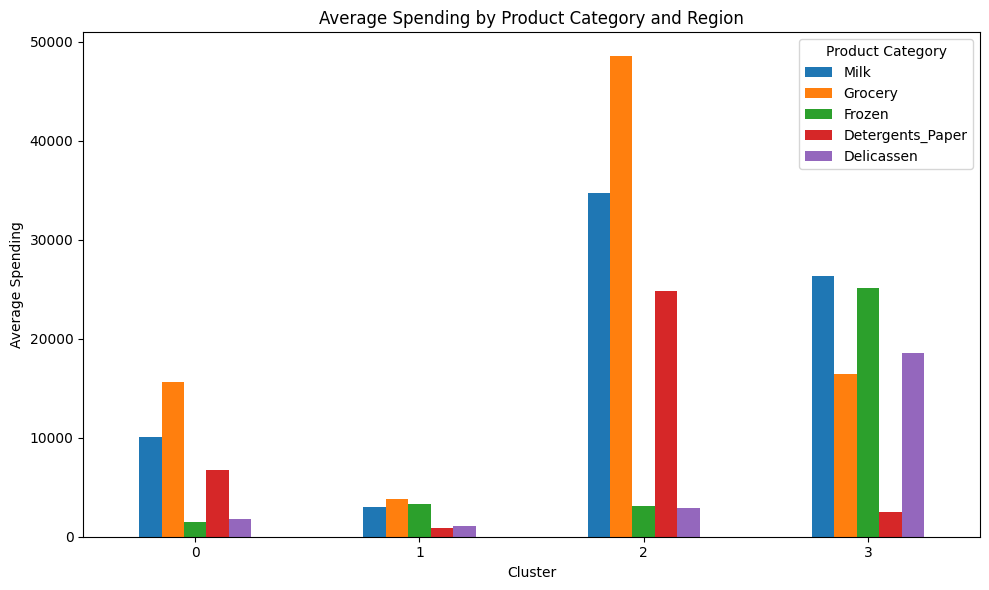

In [28]:
# Group the data by Cluster and calculate the mean
cluster_avg = wholesales[["cluster", "Milk", "Grocery","Frozen","Detergents_Paper","Delicassen"]].groupby("cluster").mean()
# Create a bar chart
cluster_avg.plot(kind="bar", figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.title('Average Spending by Product Category and Region')
plt.legend(title='Product Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
cluster_avg

,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,
0,10113.027273,15637.390909,1499.918182,6711.354545,1759.090909
1,3044.539683,3844.444444,3271.425397,852.320635,1127.107937
2,34708.500000,48536.900000,3054.600000,24875.200000,2942.800000
3,26361.800000,16416.000000,25122.800000,2475.000000,18595.200000


### Based on two bar chart above, we ccould tell that though cluster 1 and 2 spent more in total, especially in Milk and Grocery product. However, when it comes to average spending, cluster 3 and 5 spend higher because the data point is relatively less than other clusters. From this insights, we could infer that cluster 3 and 4 would be more potential clients that XYZ company could focus on. As a recommendations, I would suggest to do bundle deal promotion to boost Grocery and Milk sales together.

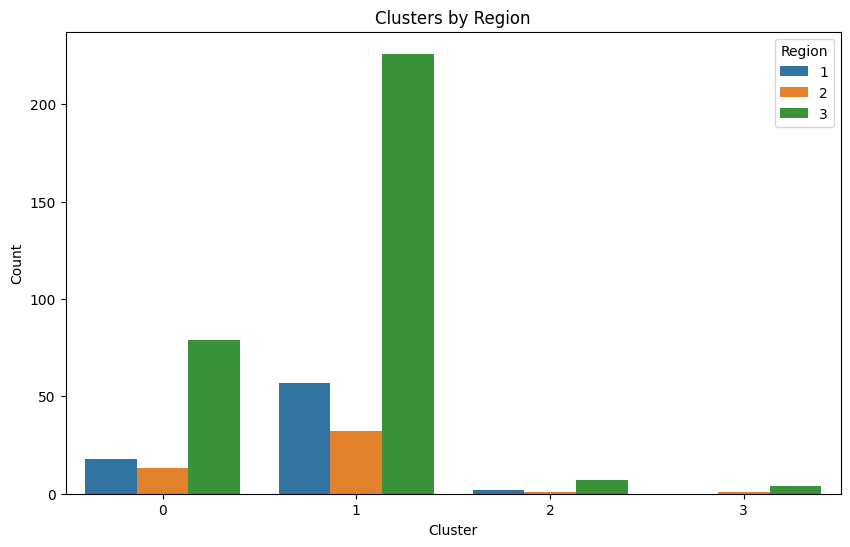

In [30]:
# Create a bar chart showing region by clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=wholesales, x='cluster', hue='Region')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Clusters by Region')
plt.legend(title='Region')
plt.show()

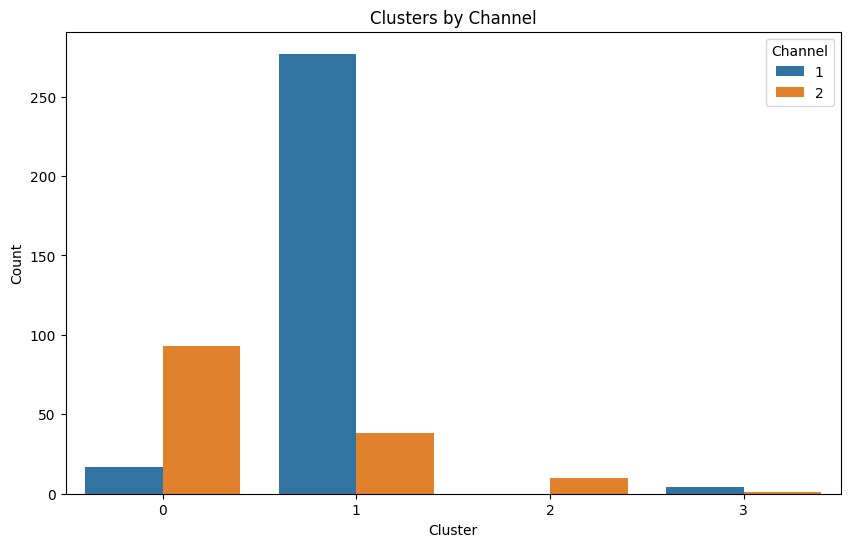

In [31]:
# Create a bar chart showing region by clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=wholesales, x='cluster', hue='Channel')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Clusters by Channel')
plt.legend(title='Channel')
plt.show()

### From region, all clusters seems to have similar patterns, which spend more on others region followed by Lisbon region.
### From channel, we would find out interesting pattern that cluster 1 focus more on Retail and clsuter two focus more on Horea.
### Hence, I would recommend that XYZ company should do inventory management based on different clsuters demands.

In [32]:
# Export the data to a CSV file with cluster information
wholesales.to_csv("wholesales_with_clusters.csv", index=False)